<a href="https://colab.research.google.com/github/Obsinaan/Autoencoders/blob/master/autoencoderoffice31_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Auotoencoder on custom datasets
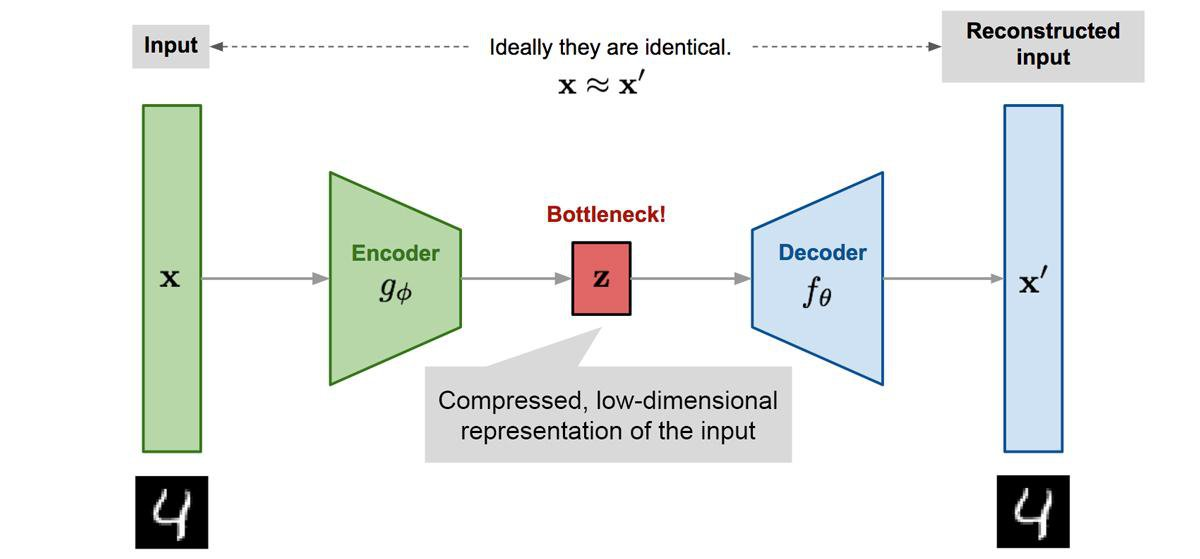

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
from keras.models import Model,Sequential
from keras.layers import Input, add
from keras.layers import Layer,Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


#Load dataset office31

In [3]:
!wget https://transferlearningdrive.blob.core.windows.net/teamdrive/dataset/office31.zip
!unzip office31.zip

--2022-03-27 22:42:51--  https://transferlearningdrive.blob.core.windows.net/teamdrive/dataset/office31.zip
Resolving transferlearningdrive.blob.core.windows.net (transferlearningdrive.blob.core.windows.net)... 20.150.17.228
Connecting to transferlearningdrive.blob.core.windows.net (transferlearningdrive.blob.core.windows.net)|20.150.17.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79531208 (76M) [application/x-zip-compressed]
Saving to: ‘office31.zip’

office31.zip        100%[===================>]  75.85M  7.32MB/s    in 13s     

2022-03-27 22:43:05 (5.87 MB/s) - ‘office31.zip’ saved [79531208/79531208]

Archive:  office31.zip
   creating: office31/
   creating: office31/amazon/
   creating: office31/amazon/back_pack/
  inflating: office31/amazon/back_pack/frame_0001.jpg  
  inflating: office31/amazon/back_pack/frame_0002.jpg  
  inflating: office31/amazon/back_pack/frame_0003.jpg  
  inflating: office31/amazon/back_pack/frame_0004.jpg  
  inflating: 

In [122]:
amazon_31='/content/office31/amazon/'
dslr_31='/content/office31/dslr'
IMAGE_SHAPE = (224,224)

In [123]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import DirectoryIterator
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [124]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_directory(
    amazon_31,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    dslr_31,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 2817 images belonging to 31 classes.
Found 498 images belonging to 31 classes.


#Vizualization of some images

In [125]:
train=tf.keras.preprocessing.image.DirectoryIterator(
    amazon_31,
    datagen,
    target_size=IMAGE_SHAPE,
    color_mode='rgb',
    classes=None,
    class_mode='input',
    batch_size=32,
    shuffle=True,
    seed=None,
    data_format=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    dtype='float32'
)

Found 2817 images belonging to 31 classes.


In [126]:
#sample_train_images, _ = next(train)
sample_val_images, _=next(valid_generator)

In [127]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

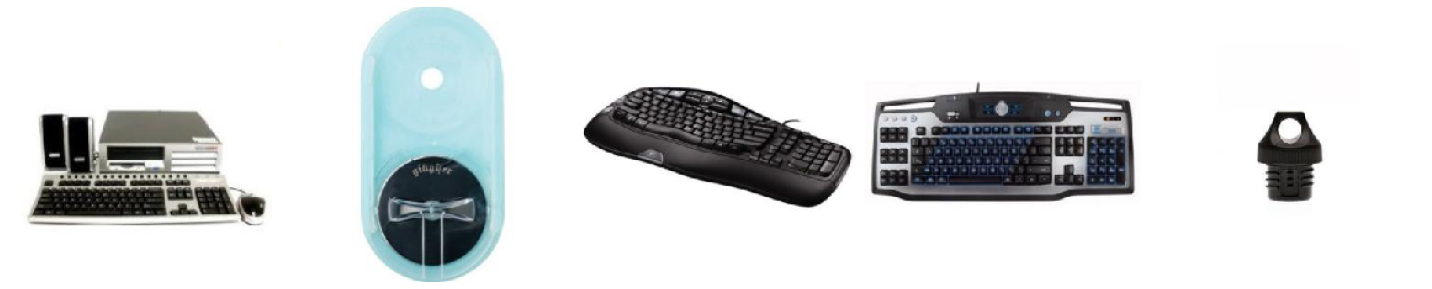

In [128]:
plotImages(sample_train_images[:5])

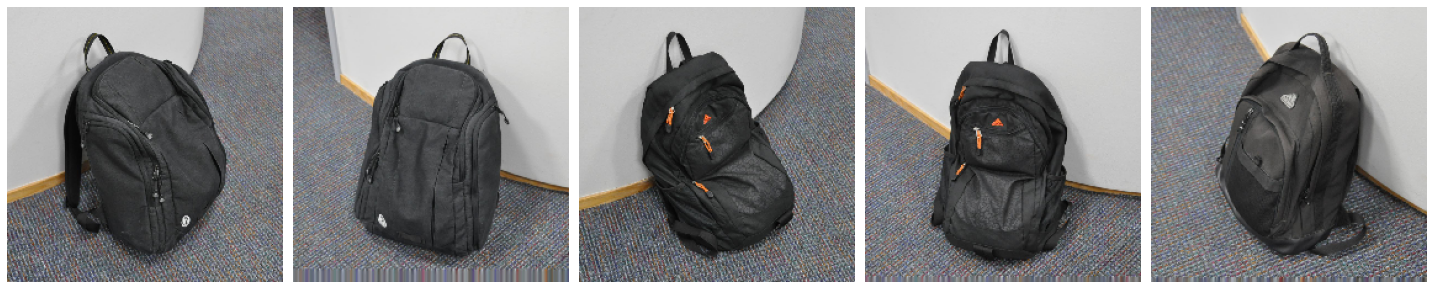

In [129]:
plotImages(sample_val_images[:5])

In [132]:
224*224*3  #rgb images

150528

#Build encoder and decoder

#Encoder

In [113]:
import tensorflow
import keras

In [133]:
x = tensorflow.keras.layers.Input(shape=(150528), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=128, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 150528)]          0         
                                                                 
 encoder_dense_1 (Dense)     (None, 128)               19267712  
                                                                 
 encoder_leakyrelu_1 (LeakyR  (None, 128)              0         
 eLU)                                                            
                                                                 
 encoder_dense_2 (Dense)     (None, 64)                8256      
                                                                 
 encoder_output (LeakyReLU)  (None, 64)                0         
                                                                 
Total params: 19,275,968
Trainable params: 19,275,968
Non-trainable params: 0
_________________________________________

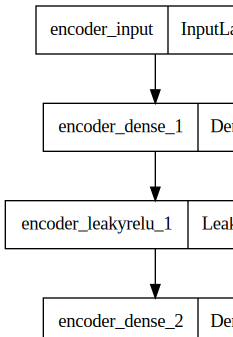

In [134]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

#Decoder

In [135]:
decoder_input = tensorflow.keras.layers.Input(shape=(64), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=128, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=150528, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 64)]              0         
                                                                 
 decoder_dense_1 (Dense)     (None, 128)               8320      
                                                                 
 decoder_leakyrelu_1 (LeakyR  (None, 128)              0         
 eLU)                                                            
                                                                 
 decoder_dense_2 (Dense)     (None, 150528)            19418112  
                                                                 
 decoder_output (LeakyReLU)  (None, 150528)            0         
                                                                 
Total params: 19,426,432
Trainable params: 19,426,432
Non-trainable params: 0
_________________________________________

#AE

In [137]:
ae_input = tensorflow.keras.layers.Input(shape=(150528), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 150528)]          0         
                                                                 
 encoder_model (Functional)  (None, 64)                19275968  
                                                                 
 decoder_model (Functional)  (None, 150528)            19426432  
                                                                 
Total params: 38,702,400
Trainable params: 38,702,400
Non-trainable params: 0
_________________________________________________________________


In [141]:
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [142]:
#x_train = np.reshape(train, newshape=(train.shape[0], np.prod(train.shape[1:])))
#x_test = numpy.reshape(x_test_orig, newshape=(x_test_orig.shape[0], numpy.prod(x_test_orig.shape[1:])))

In [145]:
# Training AE
EPOCHS = 5
BATCH_SIZE = 32
history = ae.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1
                    )


Epoch 1/5


InvalidArgumentError: ignored

In [149]:
 #This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img =Input(shape=(150528,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(150528, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [153]:
autoencoder.compile(optimizer='adam', loss='mse')

In [155]:
autoencoder.fit(train_generator,
                epochs=50,
                batch_size=256,
                shuffle=True)

Epoch 1/50


InvalidArgumentError: ignored